# Supervised Learning: Clock Drawing Image Classification with Convolutional Neural Networks
### Stacey Beck and Ian Byrne

- Split data into sets of Training (x = image arrays ; y = labels), Test (~10% image arrays), and Validation (~10% of the Training). 
- Build CNN using Pytorch for Training and Test:
  - Specify CUDA
  - 2D convolution, Normalization (for faster training), Non-linear Activation Function (ex. RELU), Max Pooling (downsampling to reduce learned parameters).
  - Define Layers 
  - Build Forward and backward pass
  - Define optimizer (due to many - deep - nodes) ex) ADAM
  - Calculate Loss (BCE)
  - Calculate Accuracy, Precision, Recall (Confusion Matrix)
  - Plot ROC and print Confusion Matrix



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# Clone the entire repo.
!git clone -l -s https://github.com/ian-byrne/MADSmilestone2.git

# Change directory into cloned repo
%cd MADSmilestone2

# List repo contents
#!ls

In [ ]:
!pip install torchmetrics

# General Libraries
import pandas as pd
import numpy as np

# Custom Libraries
import Loading.load_data as ld
import ImagePlayground.Images

# Pytroch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

# To Evaluate model
from tqdm import tqdm
import torchmetrics
from torchmetrics import ConfusionMatrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# To visualize model
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from skimage.io import imread

# To split the data
from sklearn.model_selection import train_test_split

In [ ]:
#!rm -rf /content/MADSmilestone2

# Build CNN Model using Pytorch


### Building and Training
Architecture choices influenced from: 

https://www.analyticsvidhya.com/blog/2018/12/guide-convolutional-neural-network-cnn/

https://medium.datadriveninvestor.com/five-powerful-cnn-architectures-b939c9ddd57b

https://towardsdatascience.com/how-does-sparse-convolution-work-3257a0a8fd1

In [ ]:
# Define some of the hyperparameters and training variables
#epochs = 2
#batch_size = 25
learning_rate = 1e-3
kernel_size = 3
stride = 1
padding = 1 #2*floor(3/2)

accuracy_stats = {
    'train': [],
    'val': []
}

loss_stats = {
    'train': [],
    'val': []
}
#activation function

In [ ]:
# Load numpy array files, add dimension of 1 for gray scale, and zip images and labels 
# get zipped im label and separate label tensors
tr_im_path = "Dementia_label_data/balanced_training.npy"
tr_lb_path = "Dementia_label_data/balanced_train_labels.npy"
val_im_path = "Dementia_label_data/val_im_nobal.npy"
val_lb_path = "Dementia_label_data/val_labels_im_nobal.npy"
tst_im_path = "Dementia_label_data/test_im_nobal.npy"
tst_lb_path = "Dementia_label_data/val_labels_im_nobal.npy"

training_data, y_train_tensor = ld.load_np_files(tr_im_path, tr_lb_path)
validation_data, y_val_tensor = ld.load_np_files(val_im_path, val_lb_path)
test_data, y_test_tensor = ld.load_np_files(tst_im_path, tst_lb_path)


In [8]:
# Get image data and label tensors
train_loader = torch.utils.data.DataLoader(training_data, batch_size = 64, shuffle = True, num_workers = 6) 
validate_loader = torch.utils.data.DataLoader(validation_data, batch_size = 8, shuffle = False, num_workers = 6)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 8, shuffle = False)


#Labels 
classes = (0, 1, 2)

torch.LongTensor
torch.Size([4, 1, 368, 284])


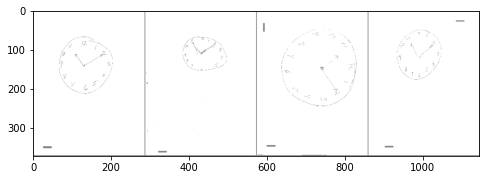

Labels:
    2              2              0              0


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
#print(images.size())
print(images.type())
#images = images.unsqueeze(1)
print(images.size())
# show images
imshow(torchvision.utils.make_grid(images, nrow = 4))
# print labels
print('Labels:')
print('          '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

#Printing as RGB, just using basic pytorch dataloader likely converting to rbg

In [9]:
# Set to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#torch.backends.cudnn.benchmark = True




class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    # without considering batch size: Input shape : (None,368, 284, 1) , parameters: (3*3*1*16+16) = 160
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 16, # one input channel gray scale, 16 filters out
                            kernel_size = 3, stride = 1, padding = 1) #Out:(None,386, 284, 16)
    self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, 
                          kernel_size = 3, stride = 1, padding = 1) #params: (3*3*16*32+32) = 4640                        
    self.pool1 = nn.MaxPool2d(2, 2) #Out: (None, 184, 142, 32)
    self.bn1 = nn.BatchNorm2d(32)

    self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, 
                          kernel_size = 3, stride = 1, padding = 1) #params: (3*3*16*32+32) = 4640    
    self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, 
                          kernel_size = 3, stride = 1, padding = 1) # params: (3*3*32*32+32) = 9248                     
    self.pool2 = nn.MaxPool2d(2, 2) #Output shape = (None, 92, 71, 64)
    self.bn2 = nn.BatchNorm2d(64) 

    self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, 
                          kernel_size = 3, stride = 1, padding = 1) # params: (3*3*32*32+32) = 9248 
    self.conv6 = nn.Conv2d(in_channels = 128, out_channels = 128, 
                          kernel_size = 3, stride = 1, padding = 1) # params: (3*3*32*32+32) = 9248
    self.pool3 = nn.MaxPool2d(2, 2) #Output shape = (None, 46, 35, 128)
    self.bn3 = nn.BatchNorm2d(128)

                             
    # Fully connected layer
    self.fc1 = nn.Linear(128*46*35,3)
    #self.fc2 = nn.Linear(120, 60)
    #self.fc3 = nn.Linear(60, 30)
    #self.fc4 = nn.Linear(30, 3) # left with 3 for the three classes                     






  def forward(self, x):
    x = self.bn1(self.pool1(F.relu(self.conv2(F.relu(self.conv1(x))))))
    x = self.bn2(self.pool2(F.relu(self.conv4(F.relu(self.conv3(x))))))
    x = self.bn3(self.pool3(F.relu(self.conv6(F.relu(self.conv5(x))))))
    x = x.view(x.size(0),128*46*35)
    #x = F.relu(self.fc1(x))
    x = self.fc1(x)
    #x = torch.softmax(self.fc1(x), dim=1)
    #print(x)

    return x                        
    """
    #Normalize each output to help w/ faster learning                       
    self.bn1 = nn.BatchNorm2d(16)
    self.pool1 = nn.MaxPool2d(2, 2) #Out: (None, 184, 142, 16)
    self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, 
                          kernel_size = 3, stride = 1, padding = 1) #params: (3*3*16*32+32) = 4640    
    self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 32, 
                          kernel_size = 3, stride = 1, padding = 1) # params: (3*3*32*32+32) = 9248                     
    self.bn2 = nn.BatchNorm2d(32) 
    #self.pool2 = nn.MaxPool2d(2, 2) #Output shape = (None, 92, 71, 32)
    self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 32, 
                          kernel_size = 3, stride = 1, padding = 1) # params: (3*3*32*32+32) = 9248 
                          
    self.conv5 = nn.Conv2d(in_channels = 32, out_channels = 32, 
                          kernel_size = 3, stride = 1, padding = 1) # params: (3*3*32*32+32) = 9248
    self.bn3 = nn.BatchNorm2d(32)                         
    # Flatten
    self.fc1 = nn.Linear(32*184*142,120)
    self.fc2 = nn.Linear(120, 60)
    self.fc3 = nn.Linear(60, 30)
    self.fc4 = nn.Linear(30, 3) # left with 3 for the three classes






  def forward(self, x):
    x = self.pool1(self.bn1(F.relu(self.conv1(x))))
    #x = self.pool2(self.bn2(F.relu(self.conv3(F.relu(self.conv2(x))))))
    x = self.bn2(F.relu(self.conv3(F.relu(self.conv2(x)))))
    x = self.bn3(F.relu(self.conv4(F.relu(self.conv5(x)))))
    x = x.view(x.size(0),32*184*142)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)

    return x"""



train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print("CUDA is available! Training on GPU...")
else:
    print("CUDA is not available. Training on CPU...")


# Create model object 
model = ConvNet()
if torch.cuda.is_available():
    model = model.to(float).cuda()
    print('Model training on GPU')

#for param in model.parameters():
  #print(str(param.data.numpy().shape)+'\n')
  #print("weights fc1: ", model.fc1.weight)
  #print("weights fc3: ", model.fc3.weight)

# Loss function
criterion = nn.CrossEntropyLoss(reduction="mean")

# Optimizer (can use SGD or ADAM)
#optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)#, momentum = 0.9) #or ADAM/ momentum
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9) #or ADAM/ momentum


print(model)






def train_val_model(epochs):
  for epoch in range(1, epochs + 1):

    # TRAINING ********************************
    train_epoch_loss = 0
    train_epoch_acc = 0

    # set model in training mode (recommended)
    model.train()

    
    # Double check
    tr_run_loss=0
    tr_correct=0
    tr_total=0
    train_accu = []
    train_losses = []
    
    print('\nEpoch$ : %d'%epoch)
    for x_train_batch, y_train_batch in tqdm(train_loader):
      x_train_batch = x_train_batch.to(float).to(device) # for GPU support
      y_train_batch = y_train_batch.to(device) 

      #print(x_train_batch.shape)

      # sets gradients to 0 to prevent interference with previous epoch
      optimizer.zero_grad()

      # Forward pass through NN
      y_train_pred = model(x_train_batch)#.to(float))
      train_loss = criterion(y_train_pred, y_train_batch)
      train_acc = accuracy(y_train_pred, y_train_batch)

      # Backward pass, updating weights
      train_loss.backward()
      optimizer.step()

      # Statistics
      train_epoch_loss += train_loss.item()
      train_epoch_acc += train_acc.item()

      # Double check scores
      tr_run_loss += train_loss.item()
     
      _, predicted = y_train_pred.max(1)
      tr_total += y_train_batch.size(0)
      tr_correct += predicted.eq(y_train_batch).sum().item()
       
    tr_loss = tr_run_loss/len(train_loader)
    accu = 100.*tr_correct/tr_total
   
    train_accu.append(accu)
    train_losses.append(tr_loss)
    print('Train Loss: %.3f | Train Accuracy: %.3f'%(tr_loss,accu))



    # VALIDATION****************************************   
    
    with torch.set_grad_enabled(False):
      val_epoch_loss = 0
      val_epoch_acc = 0

      # Double check
      val_run_loss=0
      val_correct=0
      val_total=0
      val_accu = []
      val_losses = []


      model.eval()
      for x_val_batch, y_val_batch in validate_loader:
      
        x_val_batch =  x_val_batch.to(float).to(device)
        y_val_batch = y_val_batch.to(device)
            
        # Forward pass
        y_val_pred = model(x_val_batch)   
        val_loss = criterion(y_val_pred, y_val_batch)
        val_acc = accuracy(y_val_pred, y_val_batch)
            
        val_epoch_loss += val_loss.item()
        val_epoch_acc += val_acc.item()

        # Double check
        
        val_run_loss += val_loss.item()
     
        _, predictedv = y_val_pred.max(1)
        val_total += y_train_batch.size(0)
        val_correct += predictedv.eq(y_val_batch).sum().item()
       
    vl_loss = val_run_loss/len(validate_loader)
    accuv = 100.*val_correct/val_total
   
    val_accu.append(accuv)
    val_losses.append(vl_loss)
    print('Validation Loss: %.3f | Validation Accuracy: %.3f'%(vl_loss,accuv))


    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(validate_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(validate_loader))
                              
    
    print(f'Epoch {epoch+0:03}: Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(validate_loader):.5f}') 
    print(f'Train Acc: {train_epoch_acc/len(train_loader):.3f} | Val Acc: {val_epoch_acc/len(validate_loader):.3f}')

      # Forward pass through NN
      #outputs = model(images.to(float))
      #loss = criterion(outputs, labels)

      # Backward pass, updating weights
      #loss.backward()
      #optimizer.step()
      #print(model.fc1.weight.detach().numpy())

      # Statistics 
      #running_loss += loss.item()
      # Track every 100th loss:
      #if i % 100 == 0:
        #losses.append(loss.item())
        #num_times = num_times + 1

      # print every 500th batch
      #if i % 500 == 0:
        #print("epoch: {} loss: {}".format(i, loss))
        #print('[%d %d] loss %.4f'% (epoch + 1, i + 1, running_loss/500))
        #running_loss = 0.0

    #print("\nFinished training Epoch {}\n".format(epoch + 1))
  

    # Plot the loss
    #plt.plot([i for i in range(num_times)],losses, label = 'epoch' + str(epoch))
    #plt.legend(loc = 1, mode = 'expanded', shadow = True, ncol = 2)
  #plt.show()

  #los_chart(losses)






"""
def los_chart(losses):
  plt.plot(losses)
  plt.title('loss vs epochs')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.show()
"""







def accuracy(y_pred, y_test):
  y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
  _, y_pred_prob = torch.max(y_pred_softmax, dim = 1)
  
  #y_preds = y_pred.argmax(dim=1)

  correct_pred = (y_pred_prob == y_test).float()
  #print("correct sum: ", correct_pred.sum())
  #print('correct total length: ', len(correct_pred))
  #print(correct_pred)
  acc = correct_pred.sum() / len(correct_pred)
  
  #acc = correct_pred.sum().float() / float( y_test.size(0) )

  acc = torch.round(acc * 100)

  return acc



  """
  model.eval()
  # Calculate performance
  correct = 0
  total = 0
  accuracy = 0
  with torch.set_grad_enabled(False):
      #model.to(float)
      for batches in test_loader:
        x_test, y_test = batches
        x_test = x_test.to(float).to(device)
        y_test = y_test.to(float).to(device)
        y_pred = model(x_test)
        _,y_pred = torch.max(y_pred.data, 1)# returns strongest label val and index
        total += y_test.size(0)
        #print(y_pred.size())
        #print(y_test.size())
      
        correct += (y_pred == y_test).sum().item()
        accuracy = (correct/total) * 100
      
      
      print('Accuracy = '+str(accuracy))"""


"""# TESTING****************************************   
    with torch.set_grad_enabled(False):
        
        tst_epoch_loss = 0
        tst_epoch_acc = 0
        
        model.eval()
        for x_tst_batch, y_tst_batch in test_loader:
            x_tst_batch = x_tst_batch.to(float).to(device) # for GPU support
            y_tst_batch = y_tst_batch.to(device)
            
            # Forward pass
            y_tst_pred = model(x_tst_batch)
            tst_loss = criterion(y_tst_pred, y_tst_batch)
            tst_acc = accuracy(y_tst_pred, y_tst_batch)
            
            tst_epoch_loss += tst_loss.item()
            tst_epoch_acc += tst_acc.item()"""












if __name__ == '__main__':
  train_val_model(20)













CUDA is available! Training on GPU...
Model training on GPU
ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(128, eps=1

  0%|          | 0/589 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 589/589 [03:40<00:00,  2.67it/s]

Train Loss: 3.131 | Train Accuracy: 36.210


Validation Loss: 1.211 | Validation Accuracy: 32.977
Epoch 001: Train Loss: 3.13069 | Val Loss: 1.21093
Train Acc: 36.233 | Val Acc: 61.821

Epoch$ : 2


100%|██████████| 589/589 [03:40<00:00,  2.67it/s]

Train Loss: 1.334 | Train Accuracy: 42.316


Validation Loss: 1.252 | Validation Accuracy: 24.906
Epoch 002: Train Loss: 1.33352 | Val Loss: 1.25207
Train Acc: 42.348 | Val Acc: 46.642

Epoch$ : 3


100%|██████████| 589/589 [03:40<00:00,  2.67it/s]

Train Loss: 1.095 | Train Accuracy: 47.827


Validation Loss: 4.997 | Validation Accuracy: 36.268
Epoch 003: Train Loss: 1.09541 | Val Loss: 4.99715
Train Acc: 47.942 | Val Acc: 68.003

Epoch$ : 4


100%|██████████| 589/589 [03:40<00:00,  2.67it/s]

Train Loss: 0.976 | Train Accuracy: 53.440


Validation Loss: 1.046 | Validation Accuracy: 25.702
Epoch 004: Train Loss: 0.97597 | Val Loss: 1.04577
Train Acc: 53.581 | Val Acc: 48.217

Epoch$ : 5


100%|██████████| 589/589 [03:40<00:00,  2.67it/s]

Train Loss: 0.892 | Train Accuracy: 58.598


Validation Loss: 1.081 | Validation Accuracy: 27.904
Epoch 005: Train Loss: 0.89200 | Val Loss: 1.08140
Train Acc: 58.684 | Val Acc: 52.352

Epoch$ : 6


100%|██████████| 589/589 [03:40<00:00,  2.67it/s]

Train Loss: 0.802 | Train Accuracy: 64.279


Validation Loss: 1.560 | Validation Accuracy: 17.652
Epoch 006: Train Loss: 0.80234 | Val Loss: 1.55999
Train Acc: 64.355 | Val Acc: 33.126

Epoch$ : 7


100%|██████████| 589/589 [03:40<00:00,  2.67it/s]

Train Loss: 0.723 | Train Accuracy: 68.808


Validation Loss: 4.626 | Validation Accuracy: 5.954
Epoch 007: Train Loss: 0.72257 | Val Loss: 4.62585
Train Acc: 68.795 | Val Acc: 10.978

Epoch$ : 8


 21%|██▏       | 126/589 [00:48<02:56,  2.62it/s]


KeyboardInterrupt: ignored

# Visualize the Training and Validation


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

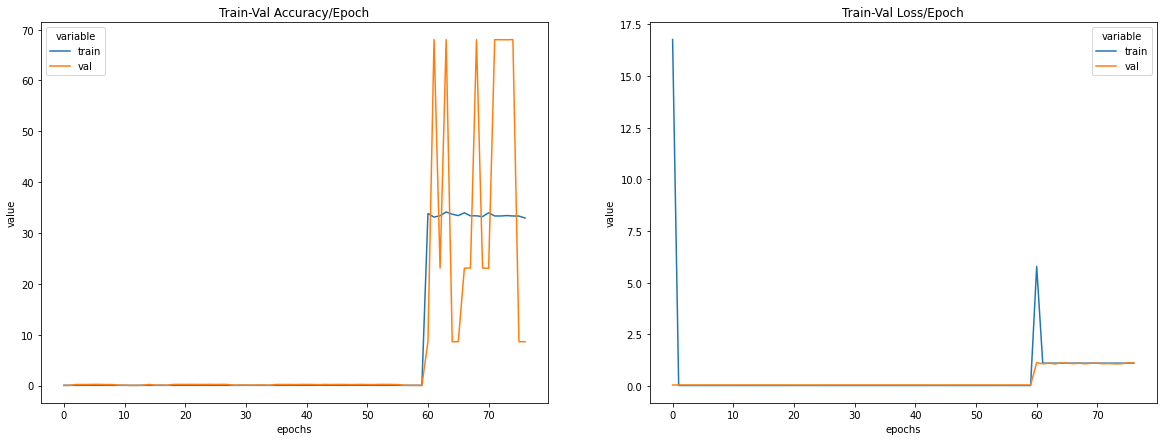

In [9]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_acc_df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/acc_loss/acc.csv', index = False)
train_val_loss_df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/acc_loss/loss.csv', index = False)
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

# Evaluate the model using Test Set

In [10]:
all_pred = []
all_preds = torch.tensor([])
y_test = torch.tensor([])
with torch.set_grad_enabled(False):
  model.eval()
  for x_test_batch, y_test_batch in test_loader:
    x_test_batch = x_test_batch.to(float).to(device)
    y_test_pred = model(x_test_batch)
    _, y_pred_probs = torch.max(y_test_pred, dim = 1)
    all_pred.append(y_pred_probs.cpu().numpy())
    all_preds = torch.cat((all_preds.cpu(), y_pred_probs.cpu()),dim = 0)
    y_test = torch.cat((y_test, y_test_batch), dim = 0) 

#all_preds = [a.squeeze().tolist() for a in all_preds]

## Create Confusion Matrix

In [11]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, all_pred))#.rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True, fmt=".2f", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

ValueError: ignored

In [22]:
"""def conf_matrix(model, loader):
  model.eval()
  all_preds = torch.tensor([])
  with torch.set_grad_enabled(False):
    for batch in loader:
      x_test, y_test = batch
      x_test = x_test.to(float).to(device)
      y_test = y_test.to(float).to(device)
      preds = model(x_test)
      # concatenates all predictions per batch into one list
      all_preds = torch.cat((all_preds.cpu(), preds.cpu()),dim = 0) 
  
  print(all_preds.size())
  print(y_test_tensor.size())
  print(y_test.size())
  print(y_train_tensor.size())
  return all_preds"""






def plot_conf_matrix(matrix, class_names, session):
  df_cm = pd.DataFrame(matrix, class_names, class_names) #matrix.numpy()
  df_cm.to_csv("/content/gdrive/MyDrive/Colab Notebooks/model_charts/conf_matrix_{}".format(session))
  plt.figure(figsize = (9,6))
  sns.heatmap(df_cm, annot=True, fmt=".2f", cmap='BuGn')
  plt.xlabel("prediction")
  plt.ylabel("label (ground truth)")
  plt.show()






from sklearn.metrics import classification_report, confusion_matrix
#all_pred = conf_matrix(model, train_loader)
#confmat = ConfusionMatrix(num_classes = 3)
#cmtx = confmat(y_train_tensor.cpu().numpy(), all_preds)
#cmtx = confmat(y_test, all_pred)
class_names = ["Possible Dementia", "Likely Dementia", "No Dementia"]
class_vals = [0,1,2]
#plot_conf_matrix(cmtx, class_names, 2)
print(classification_report(y_test, all_pred, class_vals))
#print(classification_report(y_train_tensor.numpy(), all_preds, class_vals))
#print(classification_report(y_train_tensor, all_pred.argmax(axis=1), class_vals))

              precision    recall  f1-score   support

           0       0.23      0.48      0.31       589
           1       0.11      0.08      0.09       224
           2       0.68      0.45      0.54      1728

    accuracy                           0.43      2541
   macro avg       0.34      0.34      0.32      2541
weighted avg       0.52      0.43      0.45      2541



# Plot ROC curve

ROC AUC score: 0.5022960824521454


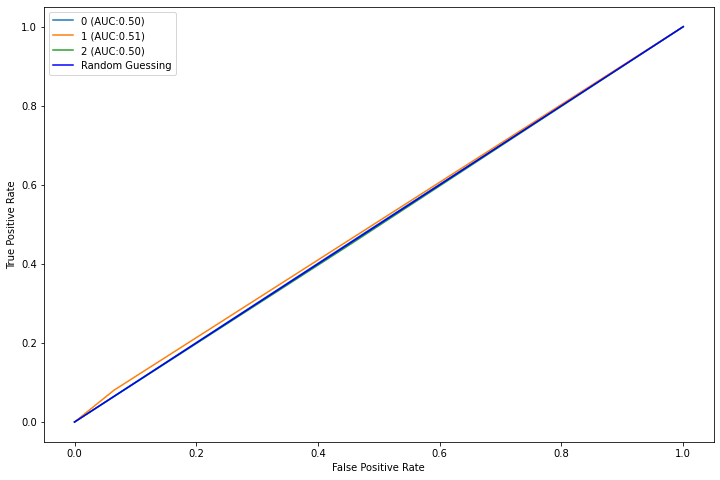

In [23]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= [0, 1, 2]

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test1, all_pred1, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test1)
    y_test1 = lb.transform(y_test1)
    all_pred1 = lb.transform(all_pred1)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test1[:,idx].astype(int), all_pred1[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test1, all_pred1, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_test, all_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [ ]:
# precision recall curve
precision = dict()
recall = dict()
n_classes = len(set(mnist.target))
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

## Save the GPU CNN Model
Also includes loading on GPU

In [24]:
# Save GPU model
model_name = 'model_cnn.checkpoint3'
PATH = "/content/gdrive/MyDrive/Colab Notebooks/Models/{}".format(model_name)
torch.save(model.state_dict(), PATH)

In [ ]:
# Load GPU model
device = torch.device("cuda")
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.to(device)

In [ ]:
# Calculate a Confusion Matrix of all the data
train_preds = get_all_preds(model, train_loader)
preds_correct = get_num_correct(train_preds, y_train_tensor)
print("total correct: ", preds_correct)
print("Accuracy_p: ", (preds_correct/len(training_data))*100)

total correct:  27692
Accuracy_p:  67.39516658959819
